# ghtop redux
> Things we learned by refactoring a CLI tool with <a href="">fastcore</a>, <a href="">rich</a>, and <a href="">ghapi</a>.

- comments: true
- toc: true
- layout: post
- hide: true
- categories: [ghapi, fastacore, python]
- image: "https://user-images.githubusercontent.com/1483922/105074862-cb955b00-5a3d-11eb-99c5-3125bb98910b.png"
- author: "<a href='https://twitter.com/HamelHusain'>Hamel Husain</a> & <a href='https://twitter.com/jeremyphoward'>Jeremy Howard</a>"
- permalink: /ghtop

![ghtop](https://user-images.githubusercontent.com/1483922/105071141-0c3ea580-5a39-11eb-8808-34952c0bf26d.gif "A demo of ghtop.")

In [27]:
#hide
from collections import Counter
from matplotlib import pyplot as plt
%matplotlib inline
from fastcore.all import *
from ghapi.all import *


[1]: https://github.com/nat/ghtop
[2]: https://github.com/fastai/ghapi

## Introduction

We recently refactored the CLI tool [ghtop][1], created by the CEO of GitHub, [Nat Friedman](https://github.com/nat).  Nat even described our refactor as a “[tour de force](https://github.com/nat/ghtop/pull/13#issuecomment-743786158)”.  This post describes what we learned along the way.

## Motivation

Recently, we released [ghapi](https://github.blog/2020-12-18-learn-about-ghapi-a-new-third-party-python-client-for-the-github-api/), a new python client for the GitHub API.  ghapi provides unparalleled ease of access to the GitHub api, as well as utilities for interacting with GitHub Actions.  Part of our motivation for creating ghapi was to accelerate the development of build, testing and deployment tools that help us in maintaining fastai projects.  

We recently started using GitHub Actions to perform a wide variety of tasks automatically like: unit and integration [tests](https://github.com/fastai/nbdev/blob/master/.github/workflows/main.yml), deploying [documentation](https://github.com/fastai/fastcore/blob/master/.github/workflows/docs.yml), building [Docker containers](https://github.com/fastai/docker-containers) and [Conda packages](https://github.com/fastai/fastconda), sharing [releases on Twitter](https://github.com/fastai/tweetrel), and much more.  This automation is key to maintaining the vast open source fastai ecosystem with very few maintainers.

Since [ghapi][2] is central to so many of these tasks, we wanted to stress-test its efficacy against other projects.  That’s when we found [ghtop][1]. This tool allows you to stream all the public events happening on GitHub to a CLI dashboard.  We thought it would be a fun learning experience to refactor this code base with various fastai tools such as [ghapi][2] and [fastcore](https://github.com/fastai/fastcore), but also try out new libraries like [rich](https://github.com/willmcgugan/rich).

## Features we added to our tools

While exploring ghtop, we added several features to various fastai tools that we found to be generally useful.

### `ghapi` Authentication

We added the function [github_auth_device](https://ghapi.fast.ai/auth.html#github_auth_device) which allows users to authenticate their api client with GitHub interactively in a browser.  When we call this function we get the following prompt:

```py
github_auth_device()
```

In [2]:
#hide-input

# This particular output is fake because it is meant to be the result an interactive session.
# This is for the purposes of formatting for the blog article.
print("""
First copy your one-time code: 276E-C910
Then visit https://github.com/login/device in your browser, and paste the code when prompted.
Shall we try to open the link for you? [y/n]
""")


First copy your one-time code: 276E-C910
Then visit https://github.com/login/device in your browser, and paste the code when prompted.
Shall we try to open the link for you? [y/n]



The browser opens a window that looks like this:
    
![](ghtop_images/token.png)

The function then returns an authenticated token which you can use for various tasks.  While this is not the only way to create a token, this is a user friendly way to create a token, especially for those who are not as familiar with GitHub.

### `ghapi` Events

As a result of our explorations with ghtop, we added an [event module](https://ghapi.fast.ai/event.html) to ghapi.  This is useful for retrieving and inspecting sample events.  Inspecting sample events is important as it allows you to prototype GitHub Actions workflows locally.  You can sample real events with `load_sample_events`:

In [3]:
from ghapi.event import load_sample_events
evts = load_sample_events()

Individual events are formatted as markdown lists to be human readable in Jupyter:

In [4]:
print(evts[0])

- id: 14517925737
- type: PushEvent
- actor: 
  - id: 17030246
  - login: BeckhamL
  - display_login: BeckhamL
  - gravatar_id: 
  - url: https://api.github.com/users/BeckhamL
  - avatar_url: https://avatars.githubusercontent.com/u/17030246?
- repo: 
  - id: 154349747
  - name: BeckhamL/leetcode
  - url: https://api.github.com/repos/BeckhamL/leetcode
- payload: 
  - push_id: 6194986903
  - size: 1
  - distinct_size: 1
  - ref: refs/heads/master
  - head: 2055b0fcf22f1c3543e38b60199f6882266d32a5
  - before: cb16921949c969b5153a0c23ce8fe516d2c8d773
  - commits: 
    - 
      - sha: 2055b0fcf22f1c3543e38b60199f6882266d32a5
      - author: 
        - email: beckham.lam@mail.mcgill.ca
        - name: Beckham Lam
      - message: Create detectCapital.ts
      - distinct: True
      - url: https://api.github.com/repos/BeckhamL/leetcode/commits/2055b0fcf22f1c3543e38b60199f6882266d32a5
- public: True
- created_at: 2020-12-13T21:32:34Z


You can also inspect the json data in an event, which are accessible as attributes:

In [5]:
evts[0].type

'PushEvent'

For example, here is the frequency of all `full_types` in the sample:

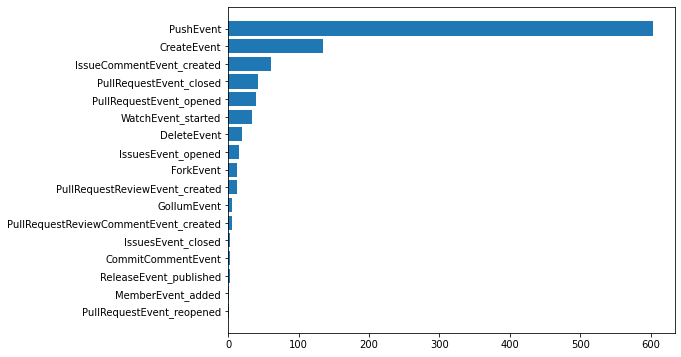

In [6]:
x,y = zip(*Counter([o.full_type for o in evts]).most_common())
plt.figure(figsize=(8, 6))
plt.barh(x[::-1],y[::-1]);

We can fetch public events in parallel with [GhApi.list_events_parallel](https://ghapi.fast.ai/event.html#GhApi.list_events_parallel).  In our experiments, **repeatedly calling `list_events_parallel` is fast enough to fetch all current public activity from all users across the entire GitHub platform.**  We use this for `ghtop`.  Behind the scenes, `list_events_parallel` uses Python's [ThreadPoolExecutor](ThreadPoolExecutor) to fetch events in parallel - no fancy distributed systems or complicated infrastructure necessary, even at the scale of GitHub!

In [7]:
%time
api = GhApi()
evts = api.list_events_parallel()
len(evts)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs


240

_Note that the GitHub API is stateless, so successive calls to the API will likely return events already seen.  We handle this by using a [set operations](https://realpython.com/python-sets/) to filter out events already seen._

### `ghapi` pagination

One of the most cumbersome aspects of fetching lots of data from the GitHub api can be [pagination](https://docs.github.com/en/rest/guides/traversing-with-pagination).  As mentioned in the documentation, different endpoints have different pagination rules and defaults.  Therefore, many api clients offer clunky or incomplete interfaces for pagination.  

In `ghapi` we added an entire module with various tools to make paging easier.  Below is an example for retrieving repos for the [github org](https://github.com/github).  Without pagination, we can only retrieve a fixed number at a time (by default 30):

In [8]:
api = GhApi()
repos = api.repos.list_for_org('fastai')
len(repos)

30

However, to get more we can paginate through `paged`:

In [9]:
from ghapi.event import paged
repos = paged(api.repos.list_for_org, 'fastai')
for page in repos: print(len(page), page[0].name)

30 fast-image
30 fastforest
30 .github
8 tweetrel


You can learn more about this functionality by [reading the docs](https://ghapi.fast.ai/page.html).

### `fastcore` Sparklines

Part of goals for refactoring ghtop were to introduce cool visualizations in the terminal of data. We drew inspiration from projects like [bashtop](https://github.com/aristocratos/bashtop), which have CLI interfaces that look like this:

<div>
<img src="https://github.com/aristocratos/bashtop/raw/master/Imgs/main.png" width="75%"/>
</div>

Concretely, we really liked the idea of sparklines in the terminal.  Therefore, we created the ability to show sparklines with fastcore:

In [10]:
from fastcore.utils import sparkline
data = [9,6,None,1,4,0,8,15,10]
print(f'without "empty_zero": {sparkline(data, empty_zero=False)}')
print(f'   with "empty_zero": {sparkline(data, empty_zero=True )}')

without "empty_zero": ▅▂ ▁▂▁▃▇▅
   with "empty_zero": ▅▂ ▁▂ ▃▇▅


For more information on this function, read [the docs](https://fastcore.fast.ai/xtras.html#sparkline). Later in this post, we will describe how we used [Rich](https://github.com/willmcgugan/rich) to add color and animation to these sparklines.  

### `fastcore` EventTimer

Because we wanted streaming event data to automatically populate sparklines, we created `EventTimer` that constructs a histogram according to a frequency and time span you set.  With `EventTimer`, you can add events with `add`, and get the number of events and their frequency:


In [11]:
from fastcore.utils import EventTimer
from time import sleep
import random

def _randwait(): yield from (sleep(random.random()/200) for _ in range(100))

c = EventTimer(store=5, span=0.03)
for o in _randwait(): c.add(1)
print(f'Num Events: {c.events}, Freq/sec: {c.freq:.01f}')
print('Most recent: ', sparkline(c.hist), *L(c.hist).map('{:.01f}'))

Num Events: 6, Freq/sec: 301.1
Most recent:  ▃▁▁▇▁ 323.6 274.8 291.3 390.9 283.6


For more information, see [the docs](https://fastcore.fast.ai/xtras.html#EventTimer).

## CLI Animations With Rich

[Rich](https://github.com/willmcgugan/rich) is an amazing python library that allows you to create beautiful, animated and interactive CLI interfaces.  Below is a preview of some its features:

<div>
<img src="https://github.com/willmcgugan/rich/raw/master/imgs/features.png" width="50%"/>
</div>

Rich also offers animated elements like spinners:

<div>
<img src="https://github.com/willmcgugan/rich/raw/master/imgs/spinners.gif" width="50%" />
</div>

... and progress bars:

<div>
<img src="https://github.com/willmcgugan/rich/raw/master/imgs/progress.gif" width="50%" />
</div>
    
While this post is not about rich, we highly recommend visiting [the repo](https://github.com/willmcgugan/rich) and [the docs](https://rich.readthedocs.io/en/latest/) to learn more.  Rich allows you to create your own custom elements.  We created two custom elements - `Stats` and `FixedPanel`, which we describe below:

### Stats: Sparklines with metrics

`Stats` renders a group of sparklines along with a spinner and a progress bar.  First we define our sparklines, the last argument being a list of event types to count:

In [12]:
from ghtop.richext import *
from ghtop.all_rich import *
console = Console()


s1 = ESpark('Issues', 'green', [IssueCommentEvent, IssuesEvent])
s2 = ESpark('PR', 'red', [PullRequestEvent, PullRequestReviewCommentEvent, PullRequestReviewEvent])
s3 = ESpark('Follow', 'blue', [WatchEvent, StarEvent])
s4 = ESpark('Other', 'red')

s = Stats([s1,s2,s3,s4], store=5, span=.1, stacked=True)
console.print(s)

Output()

You can add events to update counters and sparklines with `add_events`:

In [13]:
evts = load_sample_events()
s.add_events(evts)
console.print(s)

You can update the progress bar with the `update_prog` method:

In [14]:
s.update_prog(50)
console.print(s)

Here is what the animated version looks like:

![](ghtop_images/sparknb.gif)

### FixedPanel: A panel with fixed height

A key aspect of ghtop is showing events in different panels.  We created `FixedPanel` to allow us to arrange panels in a grid that we can incrementally add events to:

In [28]:
p = FixedPanel(15, box=box.HORIZONTALS, title='ghtop')
for e in evts: p.append(e)
grid([[p,p]])

To learn more about our extensions to `rich` see [these docs](https://ghtop.fast.ai/richext.html).

### A demo of ghtop animations

Putting all of this together, we get the following results:

**4 Panels with a sparkline for different types of events:**

![ghtop](https://user-images.githubusercontent.com/1483922/105071141-0c3ea580-5a39-11eb-8808-34952c0bf26d.gif)

**single panel with a sparkline**

![ghtop-tail](https://user-images.githubusercontent.com/1483922/105073917-91778980-5a3c-11eb-9a4c-4532b8bd338f.gif)

To learn more about ghtop, see [the docs](https://ghtop.fast.ai/).

## Interesting python features used

While making these docs, we used the following python features that at least one person we demoed it to found interesting or didn't know about.  If you have been using python for sometime, you might know about all or most of these features:

### yield from

Generators are a powerful feature of python, which are especially useful for iterating through large datasets lazily. 

### dequeue

### f-strings